In [1]:
import torch
from torch import nn

import torchvision
from torchvision.datasets import mnist, cifar
from torchvision import transforms

from torch.utils.data import DataLoader
from torch.utils.data import Subset

from matplotlib import pyplot as plt

from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [2]:
batches_per_epoch = 128
batch_size = 8

In [3]:
mnist_ds = mnist.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
# mnist_ds.train_data.to(device)
# mnist_ds.train_labels.to(device)
mnist_dl = {
    'train': DataLoader(Subset(mnist_ds, range(512, 512+1024*5)), shuffle=True, batch_size=batch_size),
    'test': DataLoader(Subset(mnist_ds, range(0, 128)), shuffle=True, batch_size=batch_size),
}

t = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
cifar_ds = cifar.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=t
)
cifar_dl = {
    'train': DataLoader(Subset(cifar_ds, range(1024, 50000)), shuffle=True, batch_size=batch_size),
    'test': DataLoader(Subset(cifar_ds, range(0, 1024)), shuffle=True, batch_size=batch_size),
}

Files already downloaded and verified


###### LeNet

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(in_features=16 * 5 * 5, out_features=120),
            nn.Sigmoid(),
            nn.Linear(in_features=120, out_features=84),
            nn.Sigmoid(),
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

###### VGG

In [5]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0,
                     dilation=1, ceil_mode=False),
    )


def fc_block(size_in, size_out):
    layer = nn.Sequential(
        nn.Linear(size_in, size_out),
        nn.BatchNorm1d(size_out),
        nn.ReLU()
    )
    return layer


class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()

        self.convs = nn.Sequential(
            conv_block(3, 64),
            conv_block(64, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )

        self.fc = nn.Sequential(
            fc_block(512, 512),
            fc_block(512, 10),
        )

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

###### ResNet

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels))
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        if in_channels != out_channels:
            self.downsaple = nn.Conv2d(in_channels, out_channels,
                                       kernel_size=3, stride=2, padding=1)
        else:
            self.downsaple = None

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsaple is not None:
            residual = self.downsaple(residual)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.layer1 = ResidualBlock(16, 16, 1)
        self.layer2 = ResidualBlock(16, 32, 2)
        self.layer3 = ResidualBlock(32, 64, 2)
        self.avgpool = nn.AvgPool2d(7, stride=2)
        self.fc = nn.Sequential(
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.ReLU(128),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

###### Train

In [7]:
def demo(model, dl, epochs=50, lr=0.001, opt_name='adam'):
    model.to(device)
    train_ac, test_ac = [], []

    opt = {
        'sgd': torch.optim.SGD,
        'adagrad': torch.optim.Adagrad,
        'adam': torch.optim.Adam,
    }[opt_name]
    optim = opt(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for e in tqdm(range(epochs)):
        if e == 200:
            optim.param_groups[0]['lr'] =  optim.param_groups[0]['lr']/10
        ac = 0
        i = 0
        for X, y in dl['train']:
            X,y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            ac += (pred.softmax(dim=1).argmax(dim=1) == y).float().mean()
            optim.zero_grad()
            loss.backward()
            optim.step()
            i += 1
            if i >= batches_per_epoch:
                break
        ac /= i
        train_ac.append(ac.cpu())

        with torch.no_grad():
            ac = 0
            for X, y in dl['test']:
                X,y = X.to(device), y.to(device)
                pred = model(X)
                ac += (pred.softmax(dim=1).argmax(dim=1) == y).float().mean()
            ac /= len(dl['test'])
            test_ac.append(ac.cpu())


    plt.plot(range(1, epochs+1), train_ac, label='train')
    plt.plot(range(1, epochs+1), test_ac, label='test')
    plt.legend()
    plt.text(
        x=epochs/2,
        y=max(max(train_ac), max(test_ac))/2,
        s=f'lr={lr};\noptim={opt_name};\nmax={train_ac[-1].item()},{test_ac[-1].item()}'
    )
    print(train_ac[-1], test_ac[-1])
    plt.show()

###### Demo

In [8]:
SGD = 'sgd'
ADAGRAD = 'adagrad'
ADAM = 'adam'

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:24<00:00,  1.23it/s]


tensor(0.1016) tensor(0.1562)


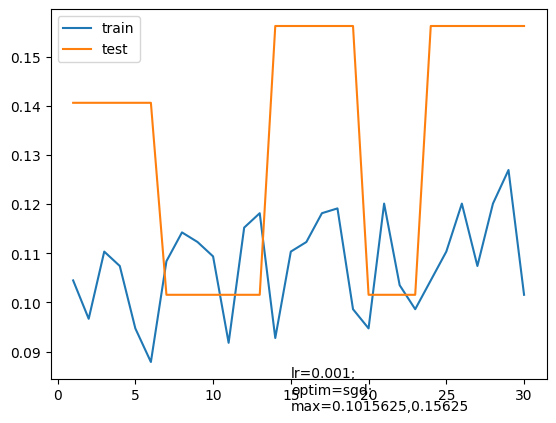

In [9]:
demo(
    LeNet(),
    mnist_dl,
    epochs=30,
    lr=0.001,
    opt_name=SGD
)

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:53<00:00,  1.12it/s]


tensor(0.8447) tensor(0.8750)


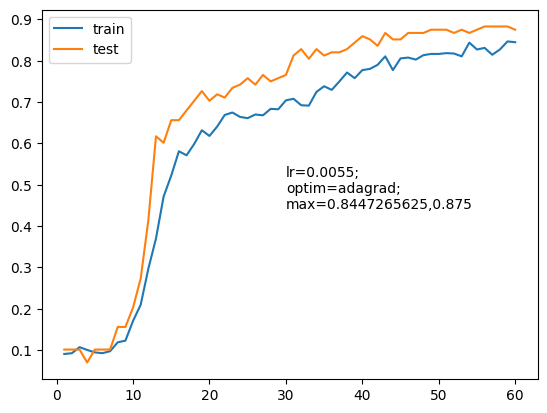

In [10]:
demo(
    LeNet(),
    mnist_dl,
    epochs=60,
    lr=0.0055,
    opt_name=ADAGRAD
)

100%|██████████| 30/30 [00:26<00:00,  1.12it/s]

tensor(0.9795) tensor(0.9688)


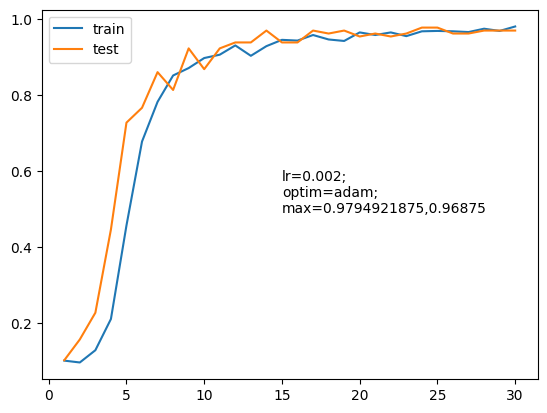

In [11]:
demo(
    LeNet(),
    mnist_dl,
    epochs=30,
    lr=0.002,
    opt_name=ADAM
)

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [23:55<00:00,  5.74s/it]


tensor(0.6553) tensor(0.6377)


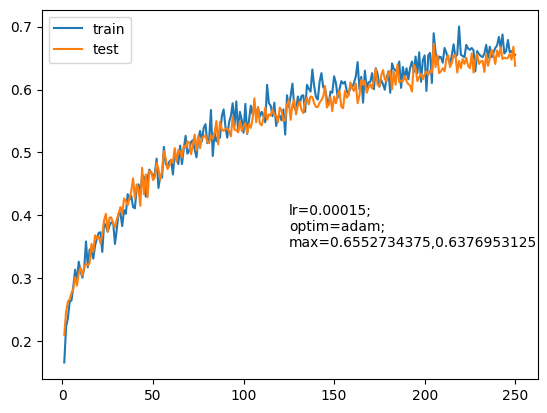

In [12]:
demo(
    ResNet(),
    cifar_dl,
    epochs=250,
    lr=0.00015,
    opt_name=ADAM
)

In [13]:
demo(
    VGG16(),
    cifar_dl,
    epochs=250,
    lr=9,
    opt_name=ADAM
)

  0%|          | 0/250 [00:12<?, ?it/s]


KeyboardInterrupt: 